In [2]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')

# path where you have this file, this is mine:
base_path = r"gdrive/MyDrive/Colab_Notebooks/DeepQL/"

data_path = base_path + r"data/"
model_path = base_path + r"model/"

# allows to import python files easily inside of collab
sys.path.append(base_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# models available
# write a name of the model to the model_file_name
!cd $model_path && ls

compare_true_profile.ipynb  song_f1  song_f3_0408_epoch232.pt



# Loading model and continuum training

In [10]:
from diffnet import F_function, W_matrix, diffNet, smooth_loss, physics_constrain, plot_f
from dataset import MyDataset, DataLoader
import torch
import torch.nn as nn

import pandas as pd
import glob
import matplotlib.pyplot as plt

data_file_name = "song_f3.csv"
model_file_name = "song_f3_0408_epoch232.pt"
working_date = "0409"

name_for_model = "song_f3"

global_model_epoch = 0
batch_size = 50


In [11]:
# Loading data
data_path = base_path + './data/'
model_path = base_path + './model/'

data = pd.read_csv( data_path + data_file_name  , index_col=0)
my_dataset = MyDataset(data)
my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# creating the model first time
# model = diffNet(depth=50)

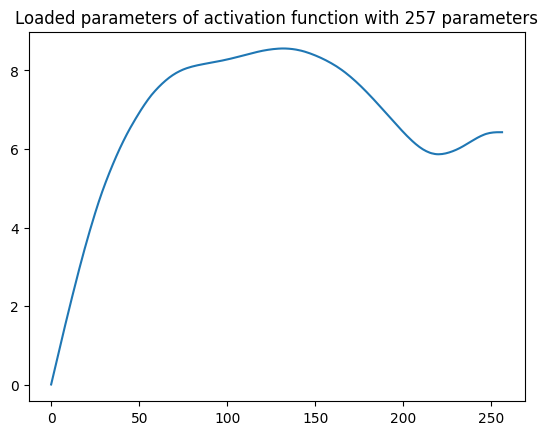

In [12]:
# Loading the model
model = torch.load( model_path + model_file_name )
# model = torch.load(model_file_name)

plt.plot(list(model.parameters())[0].detach())
N = len(list(model.parameters())[0])
plt.title(f"Loaded parameters of activation function with {N} parameters")
plt.show()


loss_array = []


In [23]:
# ========================= Hyperparameters ====================================
smooth_rate = 0.5
constrain_rate = 1.0 # F(v=0) = 0
targets_rate = 10

# Define number of epochs
num_epochs = 100

# Define loss function and optimizer
L2_loss = nn.MSELoss(reduction="sum")

optimizer = torch.optim.SGD(model.parameters(), lr=0.45)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

# ==================== end of hyperparameters ==================================

# normalization for losses
smooth_rate = smooth_rate / N
targets_rate = targets_rate / batch_size

running_loss = 0


#used for graphs
max_i = len(my_dataloader)

# Iterate through epochs
for epoch in range(num_epochs):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        L2_computed_loss = L2_loss(outputs, targets)
        # Compute loss
        loss = (smooth_rate * smooth_loss(list(model.parameters())[0]) +\
            constrain_rate*physics_constrain(list(model.parameters())[0]) + targets_rate * L2_computed_loss)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print("L2_loss:", L2_computed_loss.detach().item())
            loss_array.append(L2_computed_loss.detach().item())
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    if epoch % 100 == 10:
        # saving the model
        torch.save(model, model_path + f"{name_for_model}_{working_date}_{global_model_epoch}+epoch{epoch}.pt")
    

# finish training
global_model_epoch += epoch
torch.save(model, model_path + f"{name_for_model}_{working_date}_{global_model_epoch}.pt")
print('Finished training')

L2_loss: 2.425078868865967
[Epoch 1, Mini-batch   100] Loss: 0.289
L2_loss: 2.6155598163604736
[Epoch 1, Mini-batch   200] Loss: 0.291
L2_loss: 2.6434130668640137
[Epoch 1, Mini-batch   300] Loss: 0.286
L2_loss: 3.137791872024536
[Epoch 1, Mini-batch   400] Loss: 0.290
L2_loss: 2.795633554458618
[Epoch 1, Mini-batch   500] Loss: 0.292
L2_loss: 2.9575107097625732
[Epoch 1, Mini-batch   600] Loss: 0.289
L2_loss: 3.2110800743103027
[Epoch 1, Mini-batch   700] Loss: 0.287
L2_loss: 2.9915659427642822
[Epoch 1, Mini-batch   800] Loss: 0.290
L2_loss: 2.822916030883789
[Epoch 2, Mini-batch   100] Loss: 0.439
L2_loss: 2.9971930980682373
[Epoch 2, Mini-batch   200] Loss: 0.287
L2_loss: 2.669238567352295
[Epoch 2, Mini-batch   300] Loss: 0.287
L2_loss: 2.827183485031128
[Epoch 2, Mini-batch   400] Loss: 0.288
L2_loss: 2.7237954139709473
[Epoch 2, Mini-batch   500] Loss: 0.289
L2_loss: 2.9727485179901123
[Epoch 2, Mini-batch   600] Loss: 0.289
L2_loss: 2.533172369003296
[Epoch 2, Mini-batch   700]

KeyboardInterrupt: ignored

In [24]:
import numpy as np
def force_function(v):
    """ this function is song_f3 """
    v = np.abs(v)
    return (2.898644e-1*v-  8.043560e-3*v**2 + 9.985840e-5 *v**3 - 5.537040e-7 *v**4 + 1.284692e-9*v**5 -8.786800e-13*v**6) * (np.tanh((v-25)/20) + np.tanh((75-v)/20) + 1.5)


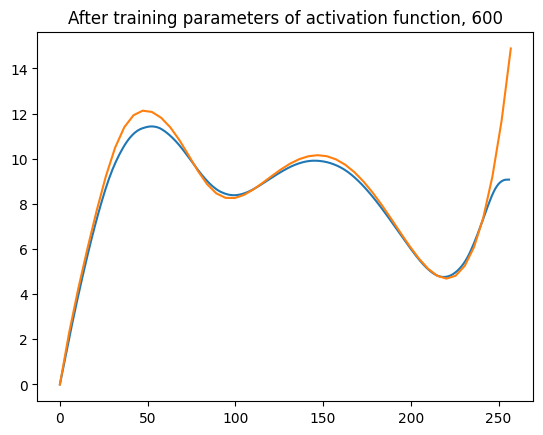

In [26]:
v = np.linspace(0, 257)
plt.plot(list(model.parameters())[0].detach(), label='model')
plt.plot(v, force_function(v))
plt.title(f"After training parameters of activation function, {global_model_epoch}")
plt.show()

In [ ]:
torch.parameters(a, b)

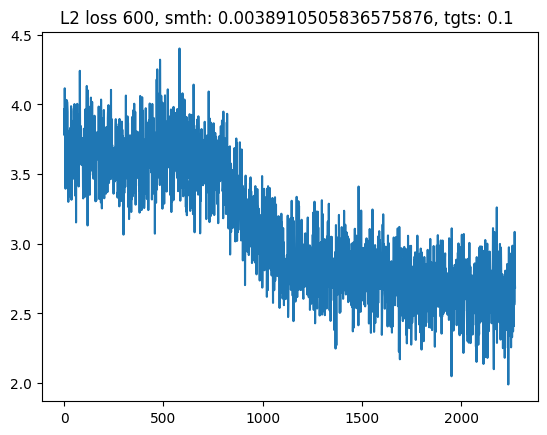

In [27]:
# plot loss
plt.plot(loss_array)
plt.title(f"L2 loss {global_model_epoch}, smth: {smooth_rate}, tgts: {targets_rate} ")
plt.savefig(f"{base_path}evolution_force")
plt.show()

In [30]:
# saving the model in folder and easy to acces
torch.save(model, f"{model_path}{name_for_model}_{working_date}_epoch{global_model_epoch}.pt")
torch.save(model, f"./{name_for_model}_{working_date}_epoch{global_model_epoch}.pt")

In [29]:
# save loss as csv
pd.DataFrame(loss_array).to_csv(f"{model_path}loss_{name_for_model}_epoch{global_model_epoch}.csv")